In [1]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import ParameterGrid
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go


# Function

In [2]:
def boxplot_by_category(data, cat_col='Cluster', figsize=(15, 10)):
  """
  Plots boxplots of numerical columns grouped by category.

  Parameters
  ----------
  data : pd.DataFrame
    DataFrame containing numerical features and category assignments.
  cat_col : str, optional
    Name of the column representing category labels (default: 'Cluster').
  figsize : tuple, optional
    Figure size for the plot (default: (15, 10)).
  """
  plt.figure(figsize=figsize, constrained_layout=True)
  numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
  numerical_cols = [col for col in numerical_cols if not col.startswith(cat_col)]
  row_len = int(np.ceil(len(numerical_cols) / 3))
  row_len = max(row_len, 1)  # Ensure at least one row

  for i, col in enumerate(numerical_cols):
    plt.subplot(row_len, 3, i + 1)
    sns.boxplot(data=data, x=cat_col, y=col, hue=cat_col, palette='cividis') # viridis
    plt.title(f'Boxplot of {col}', fontsize=12)
    plt.xlabel(cat_col, fontsize=8)
    plt.ylabel(col)
    plt.legend([], [], frameon=False)
  plt.show()

# Load Data

In [3]:
customer = pd.read_csv('Part A/customer_data.csv')
customer.drop(columns=['CustomerID'], inplace=True, errors='ignore')

# EDA

In [4]:
display(customer.head())

print("Describe statistic of Customer:")
display(customer.describe())
print("Number of null values in each column:")
print(customer.isna().sum())

,Gender,Age,Income (k$),How Much They Spend ($),Salary (k$),Spend to income ratio,Alpha
0,Male,19,15,39,1.054960,0.036968,1
1,Male,21,15,81,0.676210,0.119785,1
2,Female,20,16,6,0.562232,0.010672,1
3,Female,23,16,77,1.284359,0.059952,1
4,Female,31,17,40,0.806683,0.049586,1


Describe statistic of Customer:


,Age,Income (k$),How Much They Spend ($),Salary (k$),Spend to income ratio,Alpha
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.00000
mean,38.850000,60.560000,50.200000,4.538022,0.015816,2.50000
std,13.969007,26.264721,25.823522,2.214437,0.017091,1.12084
min,18.000000,15.000000,1.000000,0.562232,0.000157,1.00000
25%,28.750000,41.500000,34.750000,2.963534,0.008362,1.75000
50%,36.000000,61.500000,50.000000,4.577495,0.012212,2.50000
75%,49.000000,78.000000,73.000000,5.905840,0.015903,3.25000
max,70.000000,137.000000,99.000000,11.133367,0.119785,4.00000


Number of null values in each column:
Gender                     0
Age                        0
Income (k$)                0
How Much They Spend ($)    0
Salary (k$)                0
Spend to income ratio      0
Alpha                      0
dtype: int64


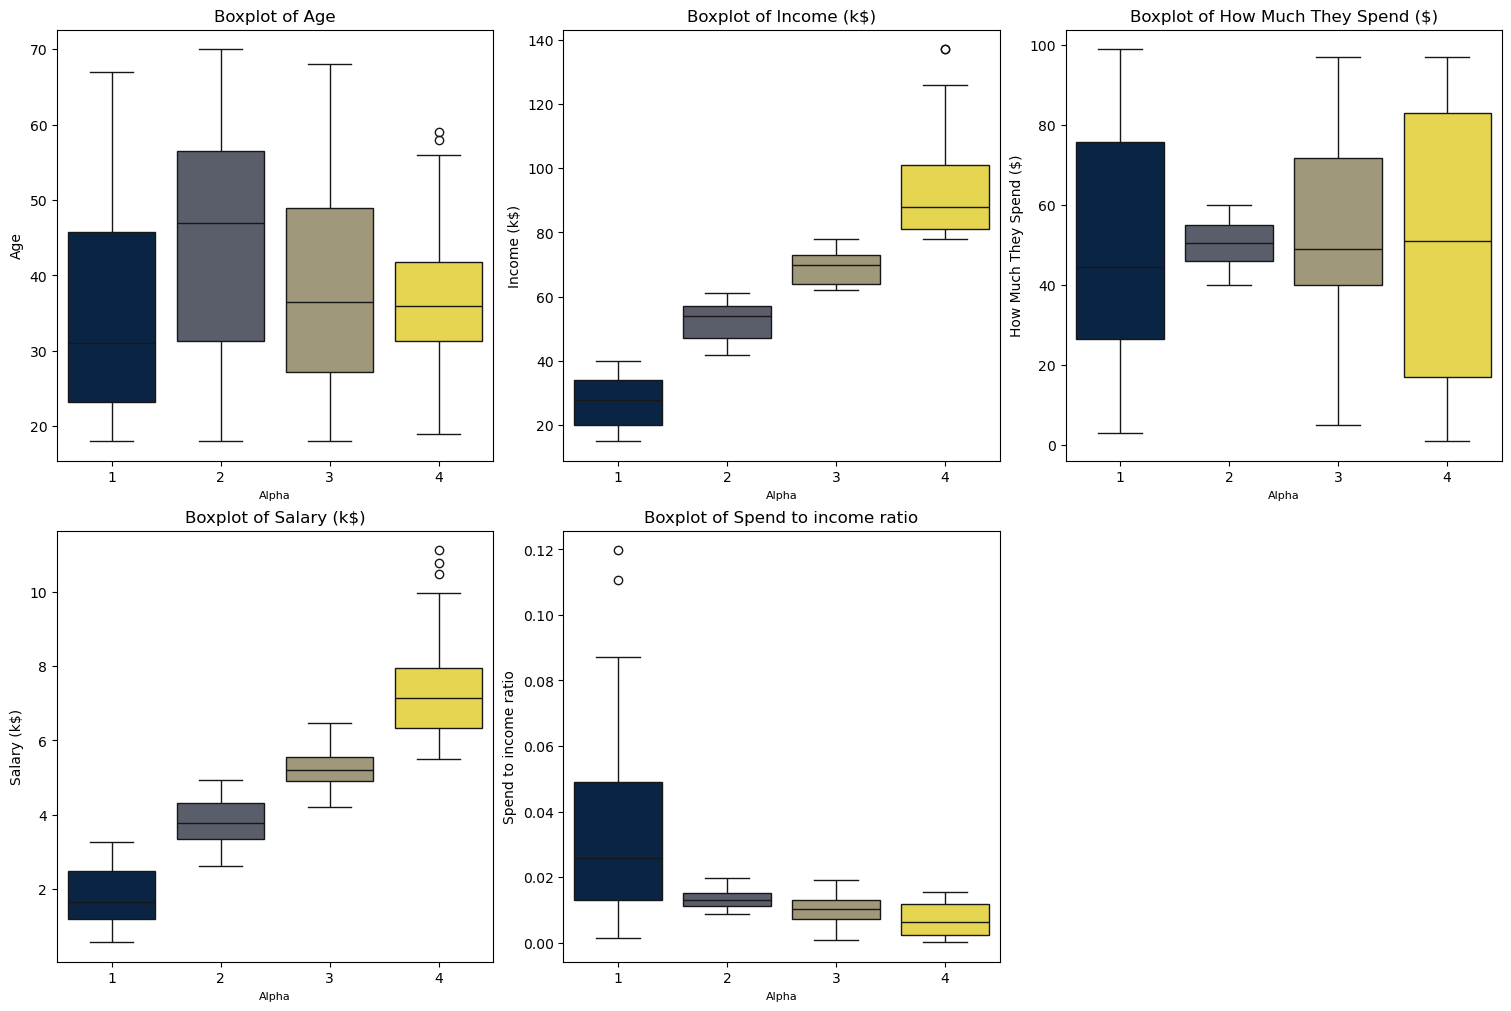

In [5]:
boxplot_by_category(customer, cat_col = "Alpha", figsize=(15, 10))

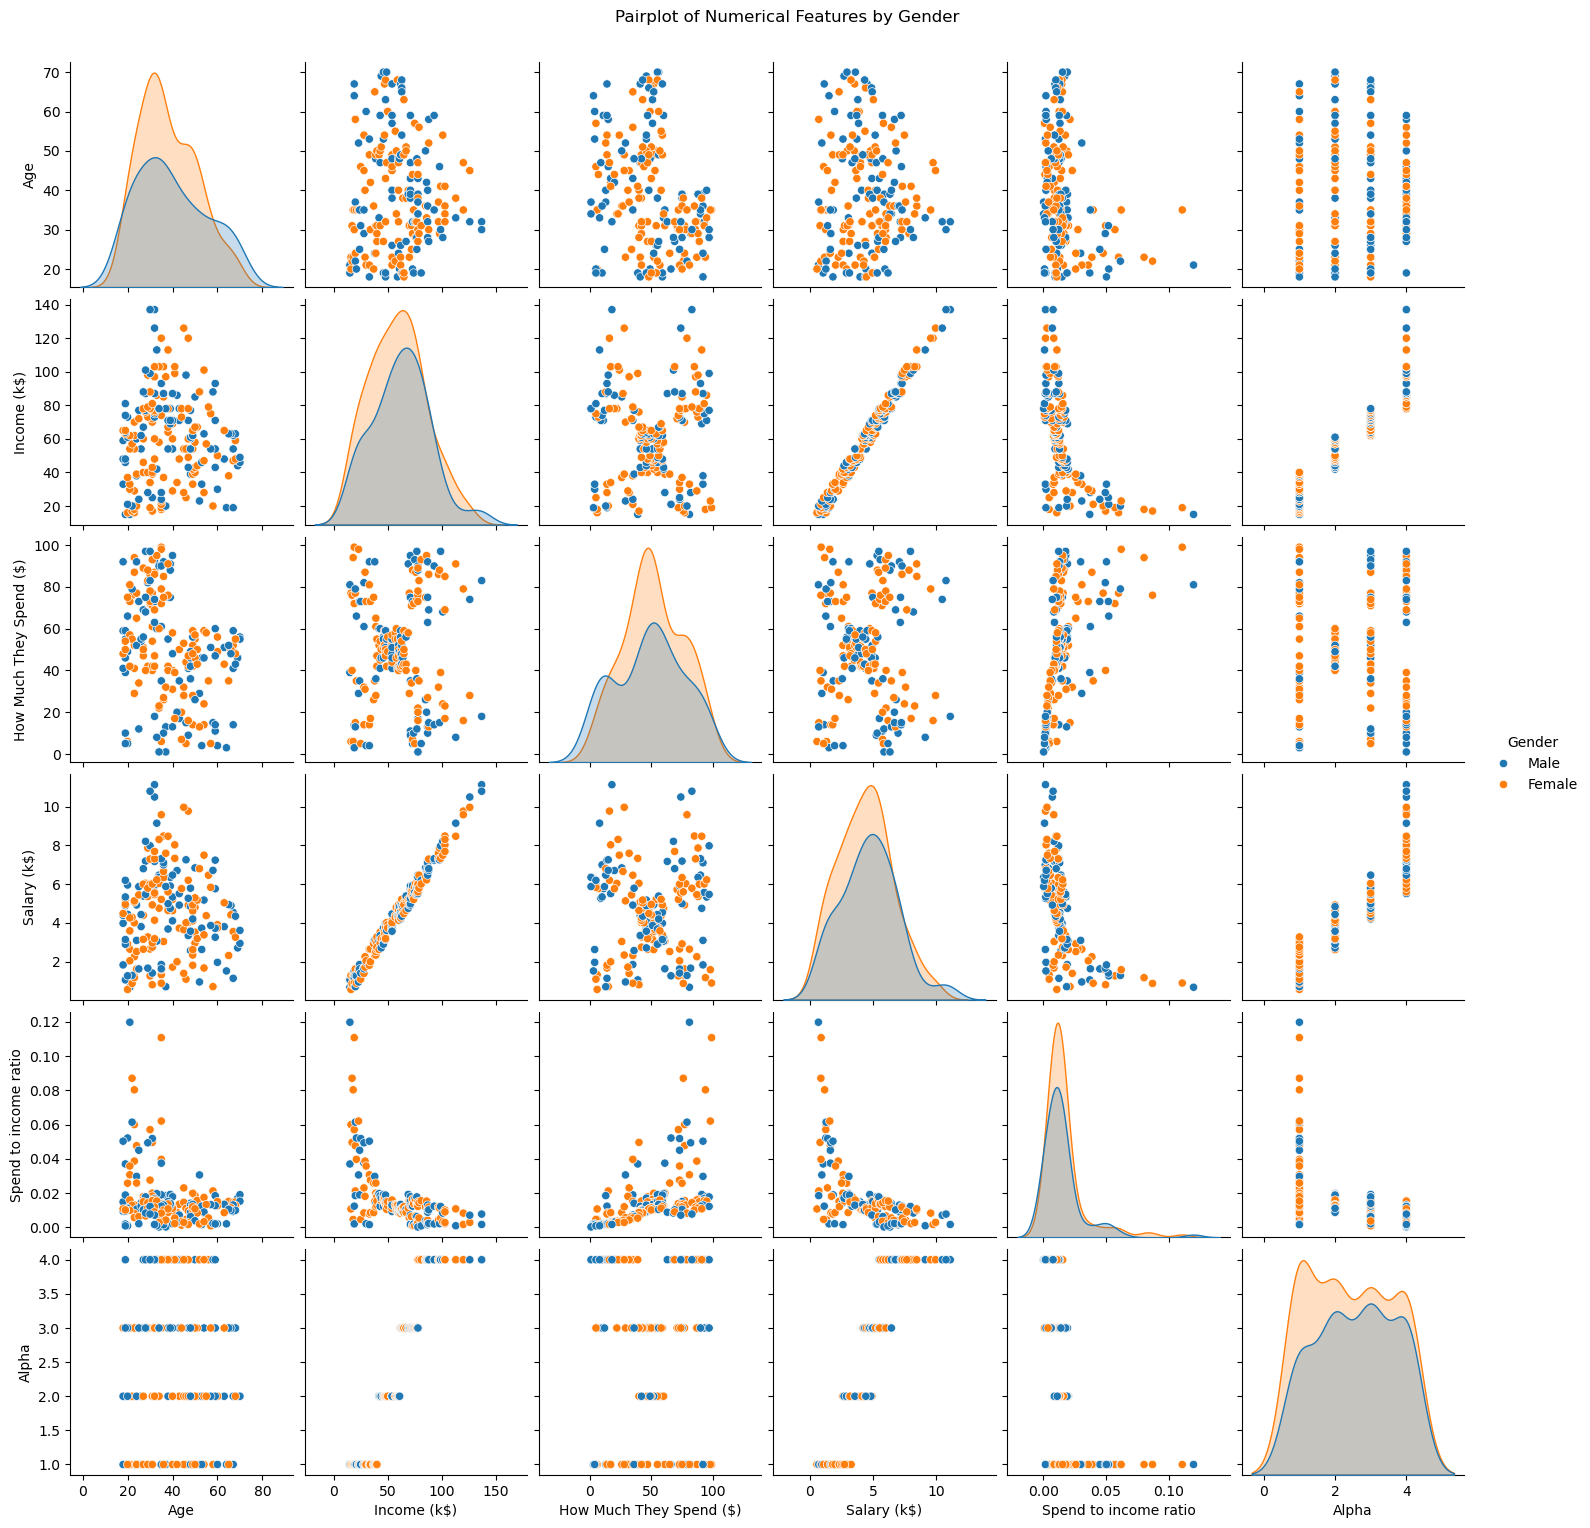

In [6]:
# pair plot to visualize relationships between numerical features
numerical_cols = customer.select_dtypes(include=['int64', 'float64']).columns.tolist()
g = sns.pairplot(customer, hue='Gender', vars=numerical_cols)
g.figure.suptitle('Pairplot of Numerical Features by Gender', y=1.02)
plt.show()

From the above pairplot, there seem to be a grouping of cluster on the spending vs income (including salary).  
There is a strong linear relationship between income and salary


# Data Transformation 
Transform the numerical features using StandardScaler to have 0 means and 1 variance.  
OneHotEncoder for Gender

In [7]:
numerical_cols = customer.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = ["Gender"]

# preprocessing steps
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer,numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

pipeline_transform = Pipeline([
    ('preprocessor', preprocessor)
])


In [8]:
customer_transform = pipeline_transform.fit_transform(customer)

categorical_feature_names = pipeline_transform.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(['Gender'])
numerical_feature_names = numerical_cols.tolist()
feature_names = np.concatenate([numerical_feature_names, categorical_feature_names]) 

customer_transform_df = pd.DataFrame(customer_transform, columns=feature_names)
print("Head of customer transform data")
display(customer_transform_df.head())
print("\nDescriptive statistics of transformed data:")
display(customer_transform_df.describe())

Head of customer transform data


,Age,Income (k$),How Much They Spend ($),Salary (k$),Spend to income ratio,Alpha,Gender_Male
0,-1.424569,-1.738999,-0.434801,-1.576835,1.240737,-1.341641,1.0
1,-1.281035,-1.738999,1.195704,-1.748301,6.098642,-1.341641,1.0
2,-1.352802,-1.700830,-1.715913,-1.799901,-0.301771,-1.341641,0.0
3,-1.137502,-1.700830,1.040418,-1.472983,2.588929,-1.341641,0.0
4,-0.563369,-1.662660,-0.395980,-1.689234,1.980859,-1.341641,0.0



Descriptive statistics of transformed data:


,Age,Income (k$),How Much They Spend ($),Salary (k$),Spend to income ratio,Alpha,Gender_Male
count,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,200.000000,2.000000e+02,200.000000
mean,-1.021405e-16,-2.131628e-16,-1.465494e-16,-7.105427e-17,0.000000,-7.105427e-17,0.440000
std,1.002509e+00,1.002509e+00,1.002509e+00,1.002509e+00,1.002509,1.002509e+00,0.497633
min,-1.496335e+00,-1.738999e+00,-1.910021e+00,-1.799901e+00,-0.918524,-1.341641e+00,0.000000
25%,-7.248436e-01,-7.275093e-01,-5.997931e-01,-7.127949e-01,-0.437284,-6.708204e-01,0.000000
50%,-2.045351e-01,3.587926e-02,-7.764312e-03,1.786994e-02,-0.211444,0.000000e+00,0.000000
75%,7.284319e-01,6.656748e-01,8.851316e-01,6.192318e-01,0.005085,6.708204e-01,1.000000
max,2.235532e+00,2.917671e+00,1.894492e+00,2.985813e+00,6.098642,1.341641e+00,1.000000


# Data Model

In [9]:
model_summary = pd.DataFrame()

## KMeans

Silhouette Score Analysis:
----------------------------------------
k= 2: Silhouette Score = 0.3088
k= 3: Silhouette Score = 0.3089
k= 4: Silhouette Score = 0.3335
k= 5: Silhouette Score = 0.3274
k= 6: Silhouette Score = 0.3505
k= 7: Silhouette Score = 0.3274
k= 8: Silhouette Score = 0.3221
k= 9: Silhouette Score = 0.2974
k=10: Silhouette Score = 0.2820

Optimal k based on Silhouette Score: 6 (Score: 0.3505)


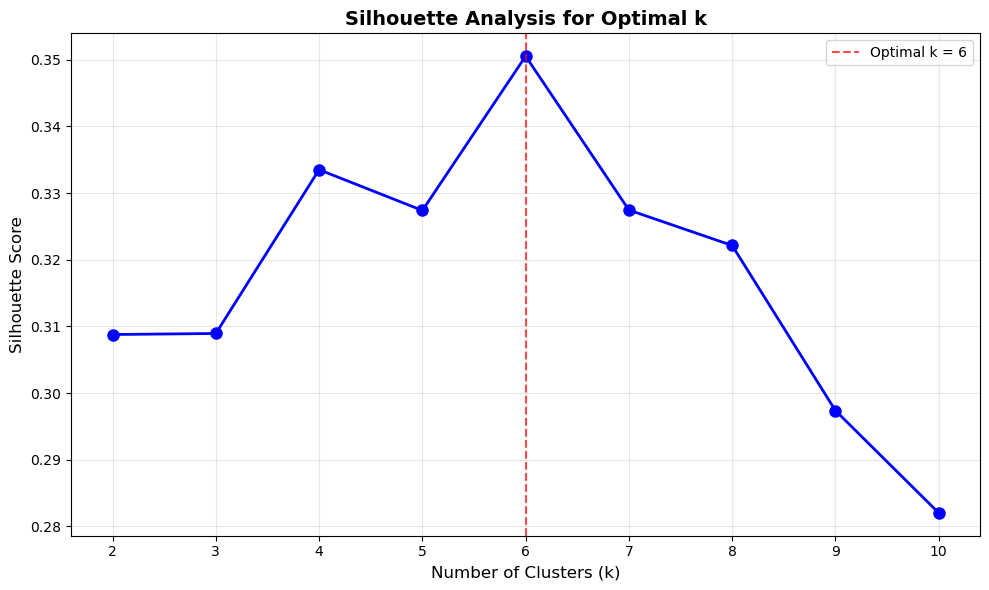

In [10]:
# Calculate silhouette scores for different k values
silhouette_scores = []
k_silhouette_mapping = {}

K = range(2, 11)

print("Silhouette Score Analysis:")
print("-" * 40)

for k in K:
  kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++')
  cluster_labels = kmeans.fit_predict(customer_transform)
  silhouette_avg = silhouette_score(customer_transform, cluster_labels, metric="euclidean")
  silhouette_scores.append(silhouette_avg)
  k_silhouette_mapping[k] = silhouette_avg
  print(f"k={k:2d}: Silhouette Score = {silhouette_avg:.4f}")

# Find optimal k based on silhouette score
if k_silhouette_mapping:  # Check if dictionary is not empty
  optimal_k = max(k_silhouette_mapping, key=k_silhouette_mapping.get)
  print(f"\nOptimal k based on Silhouette Score: {optimal_k} (Score: {k_silhouette_mapping[optimal_k]:.4f})")
else:
  print("No clusters evaluated!")
  optimal_k = 2

model_dict = {"Model Description": "KMeans with transformed customer data", "clusters": optimal_k, "silhouette score": k_silhouette_mapping[optimal_k]}

model_summary = pd.concat([model_summary, pd.DataFrame([model_dict])], ignore_index=True)

# Plotting silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, 'bo-', linewidth=2, markersize=8)
plt.title('Silhouette Analysis for Optimal k', fontsize=14, fontweight='bold')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(range(2, 11))

# Highlight optimal k
plt.axvline(x=optimal_k, color='red', linestyle='--', alpha=0.7, 
            label=f'Optimal k = {optimal_k}')
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

In [11]:
model_summary

,Model Description,clusters,silhouette score
0,KMeans with transformed customer data,6,0.35053


### KMean after PCA reduction

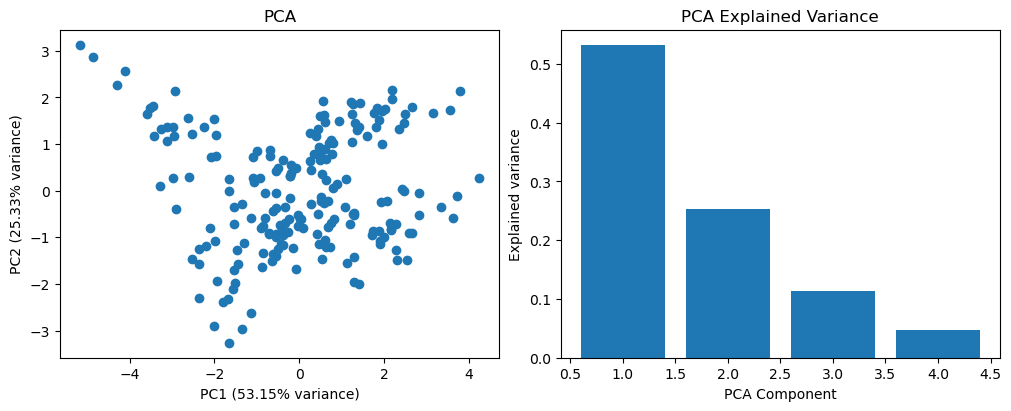

In [12]:
# Apply PCA with two components (for 2D visualization)
pca = PCA(n_components=4)
X_pca = pca.fit_transform(customer_transform)
# Plot the results

fig = plt.figure(figsize = (10, 4), layout="constrained")
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.title('PCA')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')

plt.subplot(1, 2, 2)
# Bar plot of explained_variance_ratio_
plt.bar(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
plt.xlabel('PCA Component')
plt.ylabel('Explained variance')
plt.title('PCA Explained Variance')

plt.show()


In [15]:
from sklearn.model_selection import ParameterGrid

param_grid = {"pca__n_components": [2, 3, 4],
              "kmeans__n_clusters": [2, 3, 4, 5, 6, 7, 8, 9, 10]}
grid = ParameterGrid(param_grid)
results = {}
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(random_state=42)),
    ('kmeans', KMeans(random_state=42))
])
for params in grid:
    # Set parameters for PCA and KMeans
    pipeline.set_params(**params)
    # Fit the pipeline and predict clusters
    cluster_labels = pipeline.fit_predict(customer)
    
    # Calculate silhouette score
    score = silhouette_score(pipeline.named_steps['pca'].transform(pipeline.named_steps['preprocessor'].transform(customer)), cluster_labels)
    explained_variance = pipeline.named_steps['pca'].explained_variance_ratio_.sum()
    print(f"PCA={params['pca__n_components']}, Clusters={params['kmeans__n_clusters']}: "
      f"Silhouette={score:.4f}, "
      f"Variance={explained_variance:.3f}")
    key = f"PCA_{params['pca__n_components']}_KMeans_{params['kmeans__n_clusters']}"
    results[key] = {
      'pca_components': params['pca__n_components'],
      'n_clusters': params['kmeans__n_clusters'],
      'silhouette_score': score,
      'explained_variance': explained_variance,
      # params key, value pair
      'params': params
      }





PCA=2, Clusters=2: Silhouette=0.3941, Variance=0.785
PCA=3, Clusters=2: Silhouette=0.3389, Variance=0.898
PCA=4, Clusters=2: Silhouette=0.3280, Variance=0.945
PCA=2, Clusters=3: Silhouette=0.4091, Variance=0.785
PCA=3, Clusters=3: Silhouette=0.3487, Variance=0.898
PCA=4, Clusters=3: Silhouette=0.3361, Variance=0.945
PCA=2, Clusters=4: Silhouette=0.4310, Variance=0.785
PCA=3, Clusters=4: Silhouette=0.3761, Variance=0.898
PCA=4, Clusters=4: Silhouette=0.3687, Variance=0.945
PCA=2, Clusters=5: Silhouette=0.4152, Variance=0.785
PCA=3, Clusters=5: Silhouette=0.3861, Variance=0.898
PCA=4, Clusters=5: Silhouette=0.3735, Variance=0.945
PCA=2, Clusters=6: Silhouette=0.4056, Variance=0.785
PCA=3, Clusters=6: Silhouette=0.4229, Variance=0.898
PCA=4, Clusters=6: Silhouette=0.4087, Variance=0.945
PCA=2, Clusters=7: Silhouette=0.3909, Variance=0.785
PCA=3, Clusters=7: Silhouette=0.4020, Variance=0.898
PCA=4, Clusters=7: Silhouette=0.3842, Variance=0.945
PCA=2, Clusters=8: Silhouette=0.4211, Variance

In [18]:
# Find best combinations
best_silhouette = max(results.items(), key=lambda x: x[1]['silhouette_score'])
best_variance = max(results.items(), key=lambda x: x[1]['explained_variance'])

print("ANALYSIS SUMMARY")
print(f"\nBest Silhouette Score:")
print(f"  Configuration: {best_silhouette[0]}")
print(f"  Score: {best_silhouette[1]['silhouette_score']:.4f}")
print(f"  PCA Components: {best_silhouette[1]['pca_components']}")
print(f"  Clusters: {best_silhouette[1]['n_clusters']}")
print(f"  Explained Variance: {best_silhouette[1]['explained_variance']:.3f}")

best_silhouette_params = best_silhouette[1]['params']

model_dict = {"Model Description": "KMeans with PCA of transformed customer data", "clusters": best_silhouette[1]['n_clusters'], "silhouette score": best_silhouette[1]['silhouette_score']}

model_summary = pd.concat([model_summary, pd.DataFrame([model_dict])], ignore_index=True)
model_summary

ANALYSIS SUMMARY

Best Silhouette Score:
  Configuration: PCA_2_KMeans_4
  Score: 0.4310
  PCA Components: 2
  Clusters: 4
  Explained Variance: 0.785


,Model Description,clusters,silhouette score
0,KMeans with transformed customer data,6,0.350530
1,KMeans with PCA of transformed customer data,4,0.430986
